In [68]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os, random

In [70]:
def set_seeds(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed=0):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
# Call the above function with seed value
set_global_determinism(seed=0)
    
    

In [71]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [72]:
def f(X):
    return X + 0.3*(tf.math.sin(2*pi*X) + tf.sin(4*pi*X))

In [86]:
mask

<tf.Tensor: shape=(50,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])>

In [106]:
numSamples    = 50
input_dim     = 1
hidden_dim    = 30
output_dim    = 1
learning_rate = 0.001


pi          = np.pi
Xplot       = tf.cast(tf.linspace(0, 3, 500), dtype='float32')
X           = tf.random.uniform(minval = 0, maxval = 3, shape=[numSamples], dtype='float32')
X           = tf.sort(X)
Y           = f(X);
Yplot       = f(Xplot)
noise       = tf.random.normal(Y.shape, mean=0, stddev = 0.1, dtype=Y.dtype);
mask        = tf.sequence_mask(range(10), Y.shape[0], dtype=Y.dtype) [-1]
extra_noise = tf.random.normal(Y.shape, mean=0, stddev = 0.5, dtype=Y.dtype);
extra_noise = tf.multiply(extra_noise, mask)
Y           = Y+noise + extra_noise


x_train     = tf.reshape(X, (numSamples, input_dim))
y_train     = tf.reshape(Y, (numSamples, output_dim))

In [107]:
x_train.shape

TensorShape([50, 1])

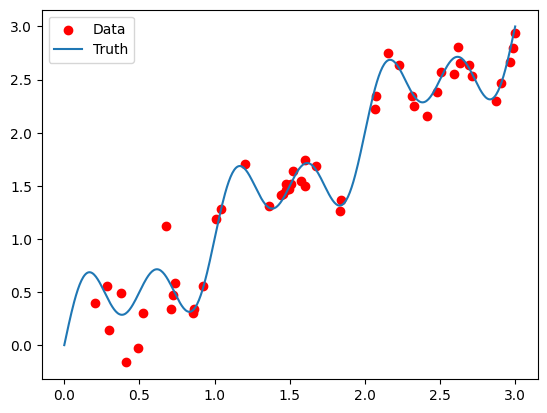

In [108]:
plt.scatter(X,Y,c='r',label='Data')
plt.plot(Xplot,Yplot, label = 'Truth')
plt.legend()

In [109]:
# Define the architecture of the neural network
class FeedForwardNN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        
        self.layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
        self.layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.layer3 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
        self.concat_layer = tf.keras.layers.Concatenate()
        
        self.confidence_layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.confidence_layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.confidence_layer3 = tf.keras.layers.Dense(output_dim, activation=None)

    def call(self, inputs):
        x      = self.layer1(inputs)
        x      = self.layer2(x)
        x      = self.layer3(x)

        output = self.output_layer(x)
        x      = self.concat_layer([x,output])
        x      = self.confidence_layer1(x)
        x      = self.confidence_layer2(x)
        s      = self.confidence_layer3(x)
        return  tf.stack([output,s])
    
    
# # Define the architecture of the neural network
# class BDeepONet(tf.keras.Model):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(BDeepONet, self).__init__()
#         self.layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
#         self.layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
#         self.layer3 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        
#         self.layer4 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
#         self.layer5 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
#         self.layer6 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        
#         self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
#         self.concat_layer = tf.keras.layers.Concatenate()
#         self.confidence_layer = tf.keras.layers.Dense(1, activation=None)

#     def call(self, inputs):
#         x      = self.layer1(inputs)
#         x      = self.layer2(x)
#         x      = self.layer3(x)
        
#         s      = tf.random.normal([50,1])
#         s      = self.layer4(s)
#         s      = self.layer5(s)
#         s      = self.layer6(s)
        

#         output = self.output_layer(tf.multiply(x,s))
#         x      = self.concat_layer([x,output])
#         sigma  = self.confidence_layer(x)
#         return  tf.stack([output,log_sigma])


In [110]:
class MyCustomLoss(tf.keras.losses.Loss):
    # initialize instance attributes
    def __init__(self, threshold=1):
        super(MyCustomLoss, self).__init__()
        self.loss_balance_param = 1

    # Compute loss
    def call(self, y_true, nn_output):
        y_pred, s = tf.unstack(nn_output)

        scaled_data_loss = 1/2*tf.multiply(tf.exp(-s) , tf.square(y_true - y_pred))

        uncertainty_loss = 1/2*s
        loss = self.loss_balance_param*scaled_data_loss + uncertainty_loss
        loss = tf.reduce_mean(loss)

        return loss

In [111]:
# Create the model
model = FeedForwardNN(input_dim, hidden_dim, output_dim)
# model = BDeepONet(input_dim, hidden_dim, output_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
              loss=MyCustomLoss())

In [112]:
model.loss.loss_balance_param =1

In [113]:
model.loss(y_train, model(x_train))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9998341>

In [114]:
model.optimizer.learning_rate = 0.01
epochs = 5000
batch_size = 64

In [115]:
# Train the model
hist = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

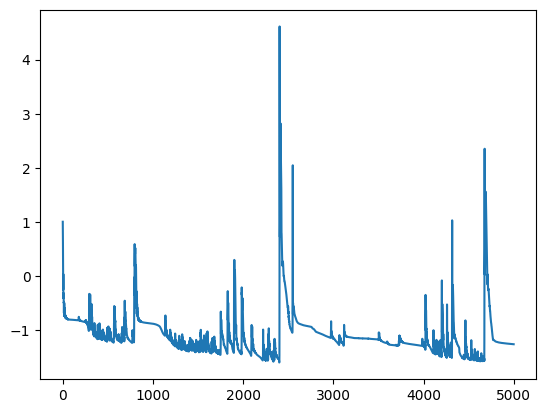

In [116]:
plt.plot(hist.history['loss'])

In [117]:
# def test_model(model, numSamples = 1000):
numSamples = 100

pi    = np.pi
X     = tf.cast(np.linspace(start=0, stop=5, num=numSamples), dtype='float32')
Y     = f(X)
X     = tf.reshape(X, (numSamples, input_dim))
out   = model(X)
y_pred, log_sigma = tf.unstack(out)


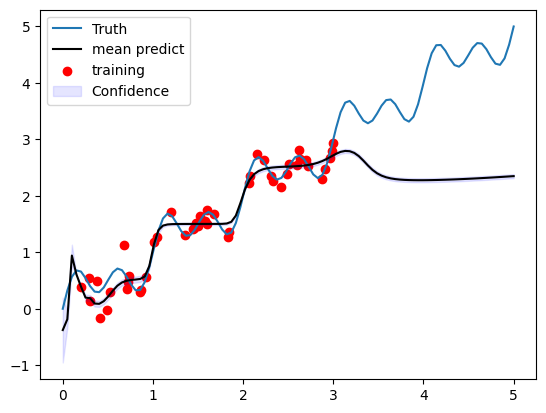

In [118]:
sig = tf.exp(log_sigma)
fig, ax = plt.subplots()
ax.plot(X,Y, label = 'Truth')
ax.plot(X, y_pred, c='k', label = 'mean predict')
ax.scatter(x_train, y_train, c='r', label = 'training')
ax.fill_between(tf.squeeze(X), tf.squeeze(y_pred-1*sig),
                tf.squeeze(y_pred+1*sig), color='b',
                alpha=.1, label = 'Confidence',
                interpolate=True)
ax.legend()
